**STEP 0: SETUP & DATA LOADING**

In [ ]:
from google.colab import drive
import pandas as pd

print("Mounting Google Drive...")
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist.csv'

df = pd.read_csv(file_path)
display(df.head())


Mounting Google Drive...
Mounted at /content/drive


,Description,Monthly_Installment,List_Price,Model,Milleage,Gear_Type,Location
0,2013/2014 BMW 528i 2.0 Sedan - M Sport service...,"RM 1,139 / month","RM 87,888",BMW 528i,145 - 150K KM,Automatic,"Selangor, Puchong"
1,2017 Honda Civic 1.8 S i-VTEC Sedan - (A) NO P...,RM 918 / month,"RM 70,800",Honda Civic,100 - 105K KM,Automatic,"Kuala Lumpur, Cheras"
2,2012 BMW 328i 2.0 Luxury Line Sedan - Luxury (...,RM 594 / month,"RM 45,800",BMW 328i,135 - 140K KM,Automatic,"Kuala Lumpur, Cheras"
3,2014 Toyota Corolla Altis 2.0 V Sedan - (A) NO...,RM 646 / month,"RM 49,800",Toyota Corolla Altis,120 - 125K KM,Automatic,"Kuala Lumpur, Cheras"
4,2013 Honda Accord 2.4 i-VTEC VTi-L Sedan - VTi...,RM 594 / month,"RM 45,800",Honda Accord,120 - 125K KM,Automatic,"Kuala Lumpur, Cheras"


**STEP 1: DATA PREPROCESSING**

In [ ]:
# --- BLOCK 1: Remove the redundant Monthly_Installment ---
import pandas as pd
import numpy as np
import re

if 'Monthly_Installment' in df.columns:
    df.drop(columns=['Monthly_Installment'], inplace=True)

df_clean = df.copy()

In [ ]:
# --- BLOCK 2: CLEAN PRICE ---
# Logic: Remove "RM" and commas ",". Convert to Number.

# 1. Remove characters
df_clean['Price'] = df_clean['List_Price'].astype(str).str.replace('RM', '').str.replace(',', '').str.strip()

# 2. Convert to numeric (Coerce errors to NaN just in case)
df_clean['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')

# Check results
print(df_clean[['List_Price', 'Price']].head())

  List_Price    Price
0  RM 87,888  87888.0
1  RM 70,800  70800.0
2  RM 45,800  45800.0
3  RM 49,800  49800.0
4  RM 45,800  45800.0


In [ ]:
# --- BLOCK 3: CLEAN MILEAGE ---

def parse_mileage(val):
    if pd.isna(val): return None
    s = str(val).upper().replace('KM', '').strip()

    # Case 1: Range (e.g., "110 - 115K")
    if '-' in s:
        try:
            parts = s.split('-')
            # Remove 'K' from both sides, convert to float
            low = float(parts[0].replace('K', '').strip())
            high = float(parts[1].replace('K', '').strip())
            # Average them and multiply by 1000
            return (low + high) / 2 * 1000
        except:
            return None

    # Case 2: Definitive Value (e.g., "95965" OR "115K")
    try:
        clean_val = float(s.replace('K', ''))
        # If it had a 'K', multiply by 1000. If it was "95965", keep as is.
        if 'K' in s:
            return clean_val * 1000
        return clean_val
    except:
        return None

df_clean['Mileage'] = df_clean['Milleage'].apply(parse_mileage)

# Check results
print(df_clean[['Milleage', 'Mileage']].head())

        Milleage   Mileage
0  145 - 150K KM  147500.0
1  100 - 105K KM  102500.0
2  135 - 140K KM  137500.0
3  120 - 125K KM  122500.0
4  120 - 125K KM  122500.0


In [ ]:
# --- BLOCK 4: EXTRACT YEAR ---

# ^      = Start of string
# \d{4}  = Exactly 4 digits (e.g., 2015)
df_clean['Year'] = df_clean['Description'].astype(str).str.extract(r'^(\d{4})').astype(float)

# Check results (Ensure 2015/2018 becomes 2015)
print(df_clean[['Description', 'Year']].head())

                                         Description    Year
0  2013/2014 BMW 528i 2.0 Sedan - M Sport service...  2013.0
1  2017 Honda Civic 1.8 S i-VTEC Sedan - (A) NO P...  2017.0
2  2012 BMW 328i 2.0 Luxury Line Sedan - Luxury (...  2012.0
3  2014 Toyota Corolla Altis 2.0 V Sedan - (A) NO...  2014.0
4  2013 Honda Accord 2.4 i-VTEC VTi-L Sedan - VTi...  2013.0


In [ ]:
# --- BLOCK 5: CLEAN STATE ---
# Logic: "Selangor, Puchong" -> Split by comma -> "Selangor"

df_clean['State'] = df_clean['Location'].astype(str).str.split(',').str[0].str.strip()

# Check unique states to ensure no messy data
print("States Found:", df_clean['State'].unique())

States Found: ['Selangor' 'Kuala Lumpur' 'Penang' 'Johor' 'Melaka' 'Perak' 'Kedah']


In [ ]:
# --- BLOCK 6: EXTRACT BRAND ---

def extract_brand(desc):
    if pd.isna(desc): return "Unknown"

    # 1. Remove the Year(s) at the start
    # Matches "2015 " or "2015/2019 "
    # ^ = Start, \d{4} = Year, (/\d{4})? = Optional second year
    clean_desc = re.sub(r'^\d{4}(/\d{4})?\s+', '', str(desc)).strip()

    # 2. Split into words
    words = clean_desc.split()
    if not words: return "Unknown"

    # 3. Handle Multi-word Brands (Specific exceptions)
    # Most brands are 1 word (Toyota, BMW). Mercedes-Benz is 1 word (hyphenated).
    # Land Rover is the main 2-word exception in Malaysia.
    if len(words) >= 2:
        first_two = f"{words[0]} {words[1]}"
        if first_two.lower() in ['land rover', 'alfa romeo', 'aston martin']:
            return first_two

    # 4. Default: Take the first word
    return words[0]

# Apply extraction
df_clean['Brand'] = df_clean['Description'].apply(extract_brand)

# Quick sanity check
print("Top 20 Brands Found:")
print(df_clean['Brand'].value_counts().head(20))

# Check for any weird extraction errors (brands appearing only once)
print("\nRare/Weird Brands (Check for errors):")
print(df_clean['Brand'].value_counts().tail(5))

Top 20 Brands Found:
Brand
Toyota           145
Honda            141
Mercedes-Benz    105
BMW               95
Mazda             73
Volkswagen        49
Perodua           43
Nissan            39
Proton            34
Lexus             28
Kia               26
Ford              23
Hyundai           22
Audi              19
Peugeot           19
Mitsubishi        16
Land Rover        16
MINI              15
Porsche           14
Subaru            13
Name: count, dtype: int64

Rare/Weird Brands (Check for errors):
Brand
Maxus        1
Citroen      1
Rover        1
Jaguar       1
Ssangyong    1
Name: count, dtype: int64


In [ ]:
# Fix 'Rover' -> 'Land Rover'
df_clean.loc[df_clean['Brand'] == 'Rover', 'Brand'] = 'Land Rover'

# Verify it's gone from the "Rare" list
print(df_clean['Brand'].value_counts().tail(10))

Brand
Isuzu        10
Volvo        10
Inokom        8
Suzuki        2
Renault       2
Haval         2
Maxus         1
Citroen       1
Jaguar        1
Ssangyong     1
Name: count, dtype: int64


In [ ]:
# --- BLOCK 7: DETERMINE ORIGIN ---

def classify_origin_from_brand(brand):
    brand = str(brand).lower()

    # Define Continental Brands
    # Since we extracted "Brand" cleanly, we can match exact words
    conti_list = [
        'bmw', 'mercedes-benz', 'audi', 'volkswagen', 'volvo', 'peugeot',
        'land rover', 'mini', 'ford', 'porsche', 'jaguar', 'renault',
        'citroen', 'ferrari', 'lamborghini', 'maserati', 'fiat'
    ]

    if brand in conti_list:
        return 'Continental'
    else:
        # Default to Asian (Toyota, Honda, Proton, Perodua, etc.)
        # This covers Inokom, Naza, etc. as well.
        return 'Asian'

df_clean['Origin'] = df_clean['Brand'].apply(classify_origin_from_brand)

print(df_clean['Origin'].value_counts())

Origin
Asian          604
Continental    370
Name: count, dtype: int64


In [ ]:
# --- BLOCK 8: EXTRACT ENGINE CAPACITY ---

def extract_engine(desc):
    if pd.isna(desc): return None

    # Regex Logic:
    # \b      = Word boundary (ensures we don't catch part of a number)
    # \d\.\d  = Digit + Dot + Digit (e.g., 1.5, 2.0, 3.0)
    # \b      = Word boundary
    match = re.search(r'\b(\d\.\d)\b', str(desc))

    if match:
        return float(match.group(0))
    return None

df_clean['Engine_L'] = df_clean['Description'].apply(extract_engine)

# Sanity Check
print("Common Engine Sizes:")
print(df_clean['Engine_L'].value_counts().head(10))

# Check for missing values (Some descriptions might miss this info)
missing_engine = df_clean['Engine_L'].isna().sum()
print(f"\nRows with missing Engine Capacity: {missing_engine}")

Common Engine Sizes:
Engine_L
2.0    356
1.5    135
2.5    107
1.6     83
1.8     62
2.4     43
1.4     31
3.0     29
3.5     22
1.3     19
Name: count, dtype: int64

Rows with missing Engine Capacity: 0


In [ ]:
# --- BLOCK 9: REVIEW EXTRACTED FEATURES ---

cols_to_check = ['Description', 'Brand', 'Origin', 'Engine_L']
display(df_clean[cols_to_check].sample(5))

,Description,Brand,Origin,Engine_L
763,2015 Honda CR-V 2.4 i-VTEC SUV - L AUTO (FACEL...,Honda,Asian,2.4
889,2019 Proton X70 1.8 TGDI Executive SUV - EASY ...,Proton,Asian,1.8
10,2014 BMW 528i 2.0 M Sport Sedan - (A) 1 YEAR W...,BMW,Continental,2.0
663,2015/2016 Volkswagen Jetta 1.4 TSI Sedan - TRU...,Volkswagen,Continental,1.4
587,2013 Toyota Innova 2.0 G MPV - (A) NO PROCESSI...,Toyota,Asian,2.0


In [ ]:
# --- BLOCK 10: SAVE CLEANED DATA ---

# Define the path (Same folder as your original file)
save_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned1.csv'

# Save to CSV (index=False prevents saving row numbers)
df_clean.to_csv(save_path, index=False)

print(f"✅ Success! Cleaned dataset saved to:\n{save_path}")

✅ Success! Cleaned dataset saved to:
/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned1.csv


In [3]:
# --- TEMPORARY RECOVERY BLOCK ---
from google.colab import drive
import pandas as pd

print("Mounting Google Drive...")
drive.mount('/content/drive')
# 1. Define path to your backup file
# (This is likely the one you saved after Block 9)
backup_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned_BackupNoModel.csv'

# 2. Load it directly into the variable 'df_clean'
df_clean = pd.read_csv(backup_path)

# 3. Verify it looks correct (Should have Brand, Engine_L, but maybe missing Model or Model is messy)
print("Backup loaded successfully.")
print(f"Rows: {len(df_clean)}")
display(df_clean.head(3))

Mounting Google Drive...
Mounted at /content/drive
Backup loaded successfully.
Rows: 974


,Description,List_Price,Model,Milleage,Gear_Type,Location,Price,Mileage,Year,State,Brand,Origin,Engine_L
0,2013/2014 BMW 528i 2.0 Sedan - M Sport service...,"RM 87,888",BMW 528i,145 - 150K KM,Automatic,"Selangor, Puchong",87888.0,147500.0,2013.0,Selangor,BMW,Continental,2.0
1,2017 Honda Civic 1.8 S i-VTEC Sedan - (A) NO P...,"RM 70,800",Honda Civic,100 - 105K KM,Automatic,"Kuala Lumpur, Cheras",70800.0,102500.0,2017.0,Kuala Lumpur,Honda,Asian,1.8
2,2012 BMW 328i 2.0 Luxury Line Sedan - Luxury (...,"RM 45,800",BMW 328i,135 - 140K KM,Automatic,"Kuala Lumpur, Cheras",45800.0,137500.0,2012.0,Kuala Lumpur,BMW,Continental,2.0


In [5]:
# --- BLOCK 10 (FIXED): EXTRACT MODEL (KEEPING BRAND) ---
import re
def infer_model_fixed(row):
    # If Model is already present and valid, keep it
    if pd.notna(row['Model']) and str(row['Model']).lower() != 'nan':
        return row['Model']

    desc = str(row['Description'])
    engine = str(row['Engine_L'])

    # Safety Check: If we don't have an engine size, we can't use this anchor logic
    if engine == 'nan' or engine == 'None':
        return "Unknown"

    # --- LOGIC: Capture text between Year and Engine ---

    # 1. Find the position of the Engine Capacity
    # We use regex boundaries \b to match "1.8" but not "11.8"
    match = re.search(r'\b' + re.escape(engine) + r'\b', desc)

    if match:
        # Take everything BEFORE the engine
        # Example: "2013 Mercedes-Benz C200 CGI "
        pre_text = desc[:match.start()].strip()

        # 2. Remove the Year(s) at the start
        # Matches "2013 " or "2010/2014 "
        model_text = re.sub(r'^\d{4}(/\d{4})?', '', pre_text).strip()

        # 3. Clean up common separators (dash/space at start)
        model_text = model_text.lstrip('- ').strip()

        return model_text

    return "Unknown"

# Apply to missing rows
missing_mask = (df_clean['Model'].isna()) | (df_clean['Model'].astype(str).str.lower() == 'n/a')
print(f"Fixing {missing_mask.sum()} rows...")

df_clean.loc[missing_mask, 'Model'] = df_clean.loc[missing_mask].apply(infer_model_fixed, axis=1)

# --- VERIFICATION ---
# Check the specific rows you mentioned to ensure they follow "Brand + Model" format
examples = df_clean[df_clean['Description'].str.contains("C200 CGI", na=False)].head(3)
display(examples[['Description', 'Model', 'Engine_L']])

Fixing 82 rows...


,Description,Model,Engine_L
170,2013 Mercedes-Benz C200 CGI 1.8 Avantgarde Sed...,Mercedes-Benz C200 CGI,1.8
270,2012/2013 Mercedes-Benz C200 CGI 1.8 AMG Sport...,Mercedes-Benz C200 CGI,1.8
460,2013 Mercedes-Benz C200 CGI 1.8 Avantgarde Sed...,Mercedes-Benz C200 CGI,1.8


In [ ]:
# Define the path (Same folder as your original file)
save_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_CleanedV2.csv'

# Save to CSV (index=False prevents saving row numbers)
df_clean.to_csv(save_path, index=False)

print(f"✅ Success! Cleaned dataset saved to:\n{save_path}")

✅ Success! Cleaned dataset saved to:
/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_CleanedV2.csv


In [6]:
# --- BLOCK 11: DROP ROWS WITH MISSING PRICE ---

# 1. Count missing prices before dropping
missing_count = df_clean['Price'].isna().sum()
print(f"Rows with missing/invalid Price: {missing_count}")

# 2. Drop rows where 'Price' is NaN
df_clean = df_clean.dropna(subset=['Price'])

# 3. Final Count
print(f"Total Rows Remaining: {len(df_clean)}")

Rows with missing/invalid Price: 5
Total Rows Remaining: 969


In [7]:
# --- STEP 1.1: DATA TRANSFORMATION ---
import numpy as np

# 1. Create 'Car_Age'
df_clean['Car_Age'] = 2022 - df_clean['Year']

# 2. Create 'Import_Status' (Refined with Domain Knowledge)
def classify_import_status(row):
    desc = str(row['Description']).lower()
    model = str(row['Model']).lower()
    year = row['Year']

    # --- PRIORITY 1: Explicit Keywords (The most accurate) ---
    if any(x in desc for x in ['unreg', 'recon', 'japan ', 'uk ', 'import']):
        return 'Import (CBU/Recon)'

    # --- PRIORITY 2: Hard-Coded "Always Import" Models ---
    # Alphards and Harriers are overwhelmingly Imports/Recon in Malaysia
    if 'alphard' in model or 'harrier' in model or 'vellfire' in model or 'navara' in model or 'audi' in model or 'ford' in model:
        return 'Import (CBU/Recon)'

    # --- PRIORITY 3: The Mazda CX-5 Case Study ---
    # Pre-2015 CX-5s were CBU.
    if 'mazda cx-5' in model:
        if year < 2015:
            return 'Import (CBU/Recon)'
        else:
            return 'Local (CKD)'

    # --- PRIORITY 4: CBU Keyword Check ---
    # We check this last to avoid false positives
    if 'cbu' in desc:
        return 'Import (CBU/Recon)'

    # Default assumption for everything else (BMW CKD, Honda City, etc.)
    return 'Local (CKD)'

df_clean['Import_Status'] = df_clean.apply(classify_import_status, axis=1)

# --- VERIFICATION ---
print(df_clean['Import_Status'].value_counts())

# Check if Alphards are correctly tagged now
alphard_check = df_clean[df_clean['Model'].str.contains("Alphard", case=False)]
print(f"\nAlphards found: {len(alphard_check)}")
if len(alphard_check) > 0:
    print(alphard_check[['Model', 'Import_Status']].head())

Import_Status
Local (CKD)           795
Import (CBU/Recon)    174
Name: count, dtype: int64

Alphards found: 30
             Model       Import_Status
14  Toyota Alphard  Import (CBU/Recon)
25  Toyota Alphard  Import (CBU/Recon)
31  Toyota Alphard  Import (CBU/Recon)
32  Toyota Alphard  Import (CBU/Recon)
38  Toyota Alphard  Import (CBU/Recon)


In [8]:
print("✅ Features Created: Car_Age, Import_Status")

print("\n--- Import Status Distribution ---")
print(df_clean['Import_Status'].value_counts())

print("\n--- Top 20 Most Common Car Models ---")
# This helps you verify which models dominate your dataset
print(df_clean['Model'].value_counts().head(20))

✅ Features Created: Car_Age, Import_Status

--- Import Status Distribution ---
Import_Status
Local (CKD)           795
Import (CBU/Recon)    174
Name: count, dtype: int64

--- Top 20 Most Common Car Models ---
Model
Mazda CX-5            33
Toyota Alphard        30
Honda City            30
Toyota Vellfire       27
Honda CR-V            26
Honda Civic           23
Perodua Myvi          20
Toyota Harrier        19
Honda HR-V            19
Honda Accord          18
Mazda 6               16
Honda Jazz            15
Toyota Vios           15
Mercedes-Benz C200    13
Mitsubishi Triton     12
BMW X1                12
Kia Cerato            11
Volkswagen Jetta      11
Nissan Navara         11
BMW 330e              11
Name: count, dtype: int64


In [9]:
# --- SAVE FINAL MASTER DATASET ---

save_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned_Final_EDA.csv'
df_clean.to_csv(save_path, index=False)

print(f"FINAL SAVE COMPLETE. Saved to:\n{save_path}")

FINAL SAVE COMPLETE. Saved to:
/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned_Final_EDA.csv


In [10]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

# Set visual style
sns.set(style="whitegrid")

# Load the data
print("Mounting Google Drive...")
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned_Final_EDA.csv'

df = pd.read_csv(file_path)
display(df.head())

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Description,List_Price,Model,Milleage,Gear_Type,Location,Price,Mileage,Year,State,Brand,Origin,Engine_L,Car_Age,Import_Status
0,2013/2014 BMW 528i 2.0 Sedan - M Sport service...,"RM 87,888",BMW 528i,145 - 150K KM,Automatic,"Selangor, Puchong",87888.0,147500.0,2013.0,Selangor,BMW,Continental,2.0,9.0,Local (CKD)
1,2017 Honda Civic 1.8 S i-VTEC Sedan - (A) NO P...,"RM 70,800",Honda Civic,100 - 105K KM,Automatic,"Kuala Lumpur, Cheras",70800.0,102500.0,2017.0,Kuala Lumpur,Honda,Asian,1.8,5.0,Local (CKD)
2,2012 BMW 328i 2.0 Luxury Line Sedan - Luxury (...,"RM 45,800",BMW 328i,135 - 140K KM,Automatic,"Kuala Lumpur, Cheras",45800.0,137500.0,2012.0,Kuala Lumpur,BMW,Continental,2.0,10.0,Local (CKD)
3,2014 Toyota Corolla Altis 2.0 V Sedan - (A) NO...,"RM 49,800",Toyota Corolla Altis,120 - 125K KM,Automatic,"Kuala Lumpur, Cheras",49800.0,122500.0,2014.0,Kuala Lumpur,Toyota,Asian,2.0,8.0,Local (CKD)
4,2013 Honda Accord 2.4 i-VTEC VTi-L Sedan - VTi...,"RM 45,800",Honda Accord,120 - 125K KM,Automatic,"Kuala Lumpur, Cheras",45800.0,122500.0,2013.0,Kuala Lumpur,Honda,Asian,2.4,9.0,Local (CKD)


**STEP 3: Exploratory Data Analysis (EDA)**

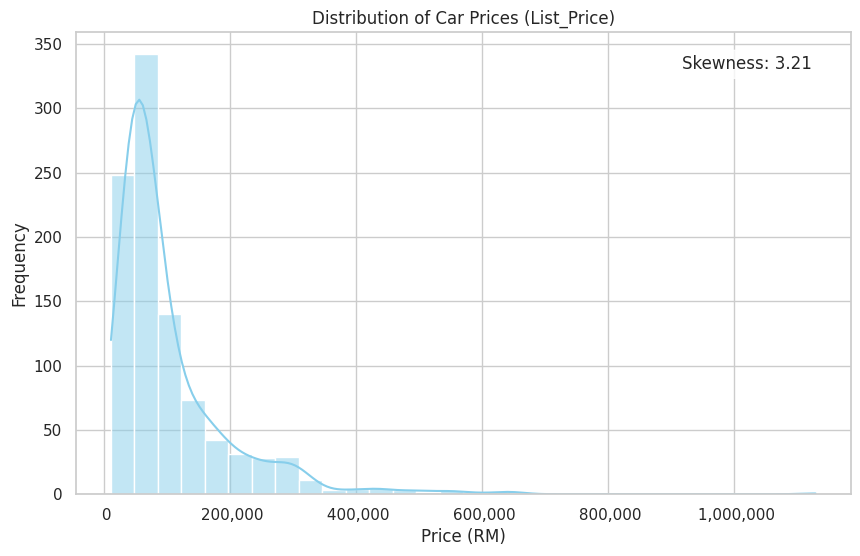

In [11]:
# Univariate Analysis (The Price Skew)
# Before testing hypotheses, we must understand the target variable: Price.
# Goal: Identify if the price is skewed and requires transformation. Logic: Most cars in Malaysia are mass-market models, creating a "long tail" of luxury cars.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# 1. Define the Currency Formatter
def currency_formatter(x, pos):
    return f' {x:,.0f}'

fmt = ticker.FuncFormatter(currency_formatter)

# 2. Calculate Skewness
price_skewness = df['Price'].skew()

# 3. Create the Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=30, color='skyblue')

# Apply formatting to X-axis (since Price is on X here)
plt.gca().xaxis.set_major_formatter(fmt)

# 4. Add Skewness Annotation
# transform=plt.gca().transAxes ensures the text stays in the top-right corner
# regardless of the data scale (0.95, 0.95 = 95% from left, 95% from bottom)
plt.text(0.95, 0.95, f'Skewness: {price_skewness:.2f}',
         transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Distribution of Car Prices (List_Price)')
plt.xlabel('Price (RM)')
plt.ylabel('Frequency')
plt.show()

**Summary**

Observation: Data is highly right-skewed (Skew > 3.0), with the vast majority of cars priced under RM 80,000.

Action: Validates the need for Log-Transformation to prevent the model from being biased by rare luxury supercars.

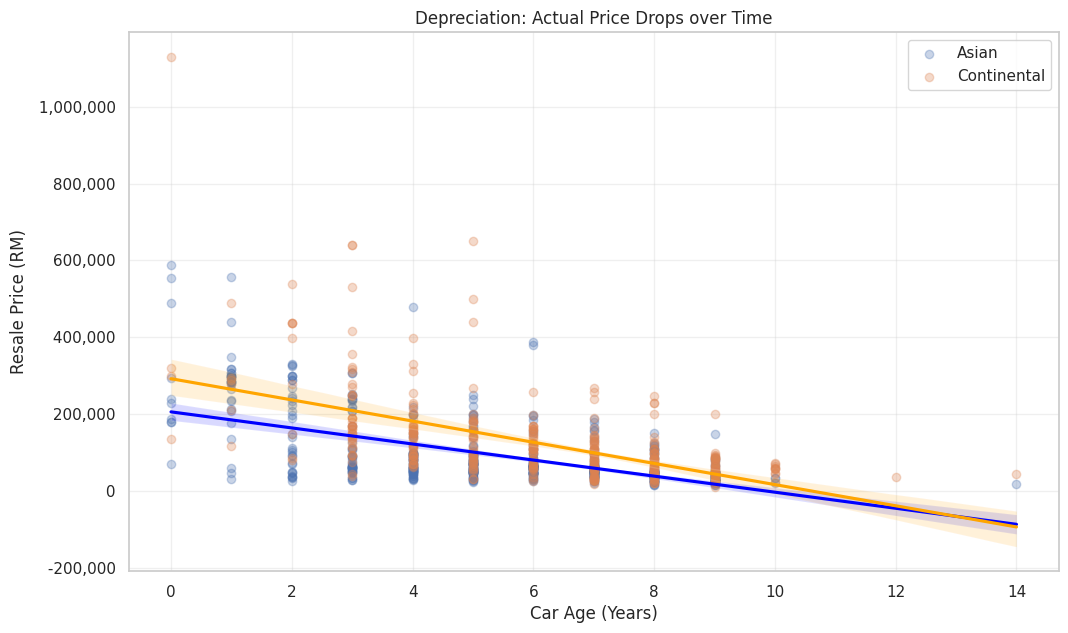

In [12]:
# Bivariate Analysis
plt.figure(figsize=(12, 7))

# Plot the regression lines
sns.regplot(data=df[df['Origin'] == 'Asian'], x='Car_Age', y='Price',
            label='Asian', scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
sns.regplot(data=df[df['Origin'] == 'Continental'], x='Car_Age', y='Price',
            label='Continental', scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})

# APPLY THE FIX: Format the Y-axis
plt.gca().yaxis.set_major_formatter(fmt)

plt.title('Depreciation: Actual Price Drops over Time')
plt.xlabel('Car Age (Years)')
plt.ylabel('Resale Price (RM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Summary**

Observation: The regression line for Continental cars (Orange) is significantly steeper than for Asian cars (Blue).

Insight: "Prestige" has a high cost—Continental brands lose value roughly 30% faster per year than their Asian counterparts.

/tmp/ipython-input-753422587.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df_multi, x='State', y='Price', col='Model',


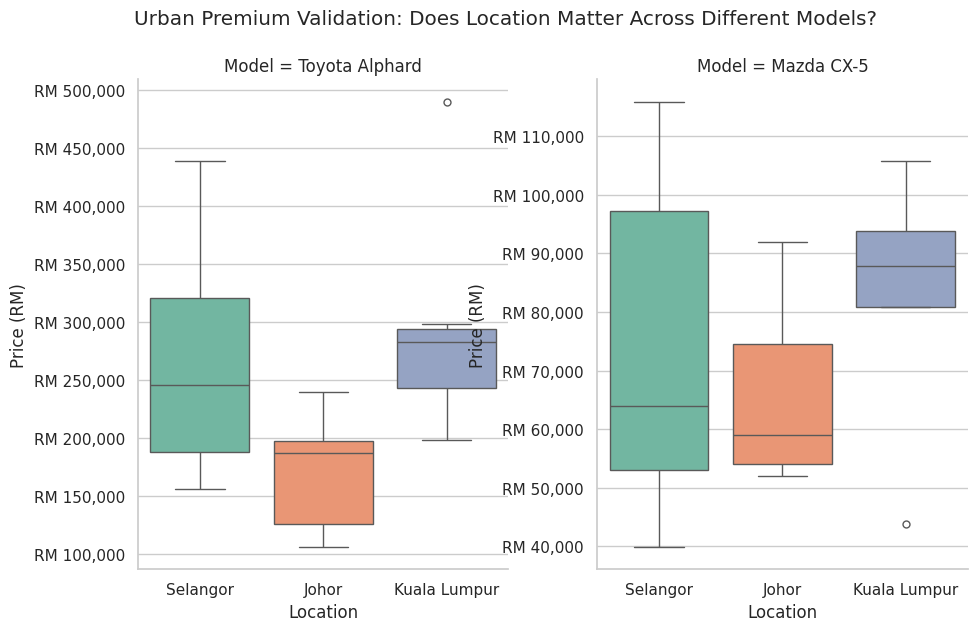

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. Define the Currency Formatter (Reusing this for clean axes)
def currency_formatter(x, pos):
    return f'RM {x:,.0f}'
fmt = ticker.FuncFormatter(currency_formatter)

# 2. Select the Models and States you want to compare
# We pick distinct segments: B-segment Sedan (City), C-segment Sedan (Civic), SUV (CX-5)
target_models = ['Toyota Alphard', 'Mazda CX-5']
target_states = ['Kuala Lumpur', 'Selangor', 'Johor']

# 3. Filter the data
df_multi = df[df['Model'].isin(target_models) & df['State'].isin(target_states)]

# 4. Create the Side-by-Side Boxplots
# kind='box': boxplot
# col='Model': create a separate graph (column) for each model
# sharey=False: allows each graph to have its own price scale (since a CX-5 costs more than a City)
g = sns.catplot(data=df_multi, x='State', y='Price', col='Model',
                kind='box', sharey=False, palette='Set2', height=6, aspect=0.8)

# 5. Apply formatting to every subplot
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xlabel('Location')
    ax.set_ylabel('Price (RM)')

# Add a main title at the top
g.fig.suptitle('Urban Premium Validation: Does Location Matter Across Different Models?', y=1.05)

plt.show()

**Summary**

Observation: Identical models (e.g. Toyota Alphard, Mazda CX-5) listed in KL/Selangor have higher median prices than those in Johor.

Insight: Location is a proxy for demand; selling in a major economic hub commands a statistically significant premium.

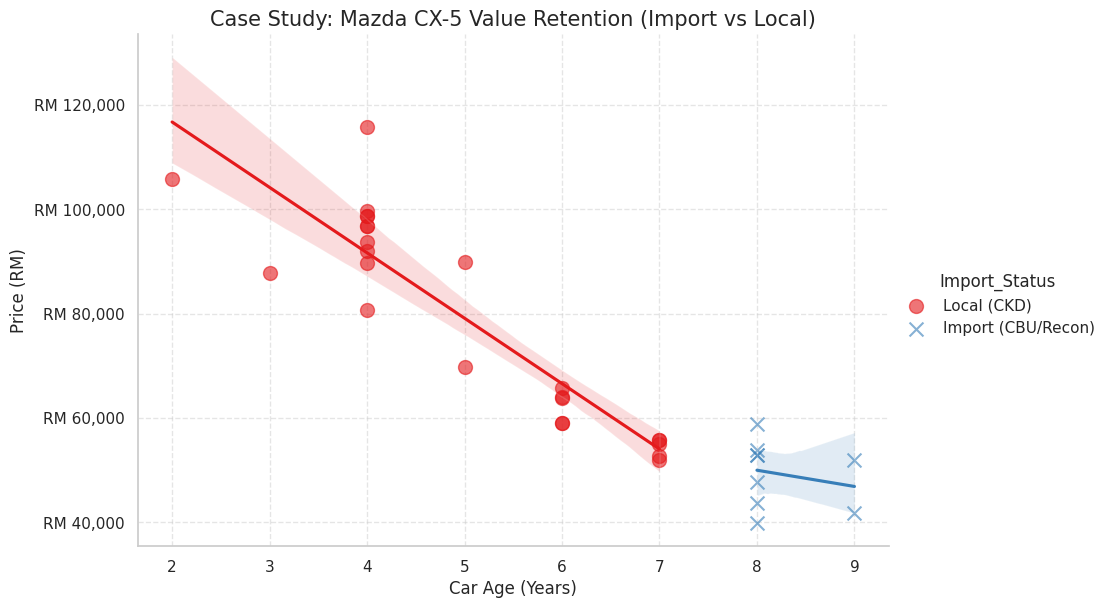

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. CRITICAL: Filter for ONLY the Case Study Car (Mazda CX-5)
# If you plot *all* cars, the graph will be a mess.
df_mazda = df_clean[df_clean['Model'].str.contains('Mazda CX-5', case=False)]

# 2. Setup formatters (Reuse your existing ones)
def currency_fmt(x, pos):
    return f'RM {x:,.0f}'
currency_formatter = ticker.FuncFormatter(currency_fmt)

# 3. Plot Regression Lines (lmplot)
# We switch X-axis to 'Car_Age' because depreciation is time-based.
# hue='Import_Status' creates two separate lines (Red vs Blue).
g = sns.lmplot(
    data=df_mazda,
    x='Car_Age',
    y='Price',
    hue='Import_Status',
    height=6,
    aspect=1.5,
    palette='Set1',
    markers=['o', 'x'],  # Different markers help distinguish overlap
    scatter_kws={'alpha': 0.6, 's': 100} # Make dots bigger and slightly transparent
)

# 4. Formatting
plt.title('Case Study: Mazda CX-5 Value Retention (Import vs Local)', fontsize=15)
plt.xlabel('Car Age (Years)', fontsize=12)
plt.ylabel('Price (RM)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Apply Currency Formatter to Y-Axis
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(currency_formatter)

plt.show()

**Summary**

Observation: In our Mazda CX-5 case study, CBU (Imported) units retain higher value than CKD (Local) units of the same age.

Insight: The market pays extra for the "Made in Japan" perception, making Import Status a crucial feature for prediction.

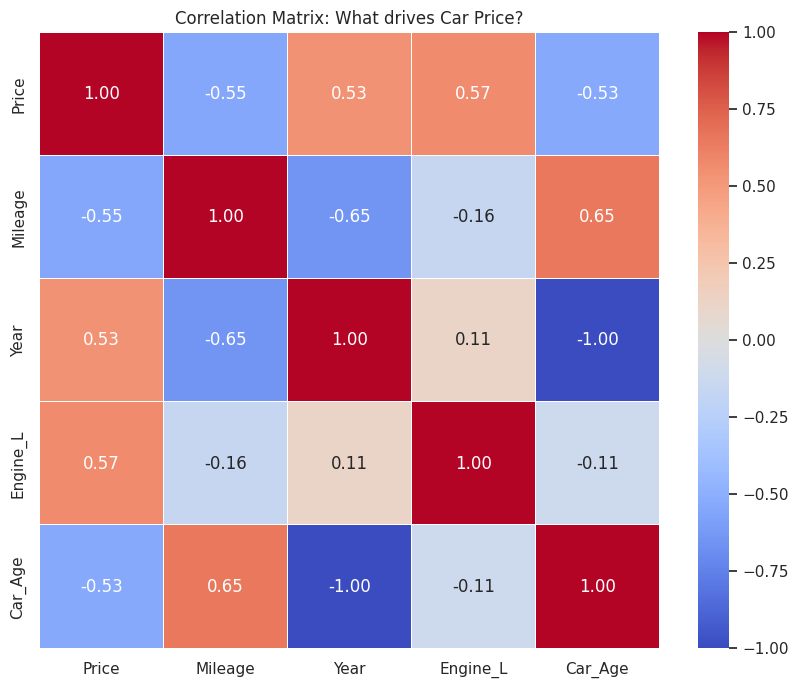

In [15]:
# --- Correlation Matrix ---
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: What drives Car Price?')
plt.show()

**Summary**

Observation: Engine Size (+0.57) and Mileage (-0.55) are the strongest predictors, with Car Age (-0.53) following close behind.

Insight: "Usage" matters more than "Age." A newer car driven extensively (high mileage) loses value faster than an older, underutilized garage queen.

Takeaway: Engine Size sets the "Price Ceiling" (Luxury vs. Budget), while Mileage determines how far it falls from that ceiling.

**Step 4: Feature Engineering**

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- FIX: LOAD THE DATA INTO 'df_clean' FIRST ---
file_path = '/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Cleaned_Final_EDA.csv'
df_clean = pd.read_csv(file_path)

# --- STEP 1: ADVANCED FEATURE ENGINEERING ---
# 1. Create 'Log_Price'
df_clean['Log_Price'] = np.log1p(df_clean['Price'])

# 2. Create 'Annual_Mileage' (Usage Intensity)
df_clean['Annual_Mileage'] = df_clean['Mileage'] / df_clean['Car_Age'].replace(0, 1)

# 3. Create 'Has_Warranty' (Text Mining)
df_clean['Has_Warranty'] = df_clean['Description'].astype(str).str.lower().apply(
    lambda x: 1 if 'warranty' in x else 0
)

# 1. Verify the columns are in Python's memory
print("Columns in DataFrame:", df_clean.columns)

# 2. SAVE the changes to a new CSV file
df_clean.to_csv('/content/drive/My Drive/WIA1007/Malaysia_Resale_Carlist_Engineered.csv', index=False)

print("Success! New file 'Malaysia_Resale_Carlist_Feature_Engineered.csv' created with new columns.")
# --- STEP 2: PREPARE DATA FOR TRAINING ---

# 1. Define Features (X) and Target (y)
features = [
    'Car_Age', 'Mileage', 'Annual_Mileage', 'Engine_L', 'Has_Warranty', # Numerical
    'Brand', 'Origin', 'State', 'Import_Status',                           # Categorical
]

X = df_clean[features]
y = df_clean['Log_Price'] # Target

# 2. One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=['Brand', 'Origin', 'State', 'Import_Status'], drop_first=True)

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("--- Data Ready for Modeling ---")
print(f"Training Features: {X_train.shape[1]} columns")
print(f"Training Samples:  {X_train.shape[0]} rows")

Columns in DataFrame: Index(['Description', 'List_Price', 'Model', 'Milleage', 'Gear_Type',
       'Location', 'Price', 'Mileage', 'Year', 'State', 'Brand', 'Origin',
       'Engine_L', 'Car_Age', 'Import_Status', 'Log_Price', 'Annual_Mileage',
       'Has_Warranty'],
      dtype='object')
Success! New file 'Malaysia_Resale_Carlist_Feature_Engineered.csv' created with new columns.
--- Data Ready for Modeling ---
Training Features: 42 columns
Training Samples:  775 rows


**Step 5: Model Selection & Comparison**

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. MODEL A: Linear Regression (The Baseline) ---
# Goal: Test if a simple straight-line equation works.
print("Training Model A: Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr_log = lr.predict(X_test)
# Inverse Log (Convert back to RM)
y_pred_lr = np.expm1(y_pred_lr_log)
y_true = np.expm1(y_test)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))
r2_lr = r2_score(y_true, y_pred_lr)

print(f"--- Linear Regression Results ---")
print(f"RMSE: RM {rmse_lr:,.0f} (Avg Error)")
print(f"R2 Score: {r2_lr:.4f} (Accuracy: {r2_lr*100:.1f}%)")
print("-" * 30)


# --- 2. MODEL B: Random Forest (The Challenger) ---
# Goal: Test if a complex decision tree works better.
print("\nTraining Model B: Random Forest (This might take a moment)...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf_log = rf.predict(X_test)
# Inverse Log (Convert back to RM)
y_pred_rf = np.expm1(y_pred_rf_log)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_true, y_pred_rf))
r2_rf = r2_score(y_true, y_pred_rf)

print(f"--- Random Forest Results ---")
print(f"RMSE: RM {rmse_rf:,.0f} (Avg Error)")
print(f"R2 Score: {r2_rf:.4f} (Accuracy: {r2_rf*100:.1f}%)")
print("-" * 30)


# --- 3. THE VERDICT ---
print("\n=== 🏆 FINAL VERDICT ===")
if r2_rf > r2_lr:
    diff = rmse_lr - rmse_rf
    print(f"WINNER: Random Forest!")
    print(f"Why: It reduced the prediction error by RM {diff:,.0f} per car compared to the simple model.")
    print("Insight: Car depreciation is non-linear (the 'Badge Tax' curve), so the advanced model captured it better.")
else:
    print(f"WINNER: Linear Regression!")
    print(f"Why: The data is simple enough that we don't need a complex AI.")

Training Model A: Linear Regression...
--- Linear Regression Results ---
RMSE: RM 36,975 (Avg Error)
R2 Score: 0.8130 (Accuracy: 81.3%)
------------------------------

Training Model B: Random Forest (This might take a moment)...
--- Random Forest Results ---
RMSE: RM 26,377 (Avg Error)
R2 Score: 0.9048 (Accuracy: 90.5%)
------------------------------

=== 🏆 FINAL VERDICT ===
WINNER: Random Forest!
Why: It reduced the prediction error by RM 10,599 per car compared to the simple model.
Insight: Car depreciation is non-linear (the 'Badge Tax' curve), so the advanced model captured it better.


**Step 6: Modal Training**

Hyperparameter Tuning (Making the Winner Smarter)

In [22]:
from sklearn.model_selection import GridSearchCV

# 1. Define the "Grid" of settings to test
# We will test 2 x 2 x 2 = 8 different combinations.
param_grid = {
    'n_estimators': [100, 200],       # Number of trees (More is usually better but slower)
    'max_depth': [None, 20],          # How deep can each tree go? (None = unlimited)
    'min_samples_split': [2, 5]       # Minimum cars needed to split a node
}

# 2. Initialize the Grid Search
# cv=3 means "Cross Validation": It splits the data 3 ways to ensure the result is consistent.
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# 3. Run the Search (This takes time!)
print("Tuning the model... (This might take 1-2 minutes)")
grid_search.fit(X_train, y_train)

# 4. Get the Best Results
best_rf = grid_search.best_estimator_
print("\n--- Tuning Complete ---")
print(f"Best Settings Found: {grid_search.best_params_}")

# 5. Evaluate the "Tuned" Model
y_pred_tuned_log = best_rf.predict(X_test)
y_pred_tuned = np.expm1(y_pred_tuned_log) # Convert back to RM

r2_tuned = r2_score(y_test, y_pred_tuned_log) # Compare Log vs Log for fairness
rmse_tuned = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_tuned))

print(f"\nFinal Accuracy (Tuned Random Forest):")
print(f"  R2 Score: {r2_tuned:.4f} ({r2_tuned*100:.1f}%)")
print(f"  RMSE: RM {rmse_tuned:,.0f}")

Tuning the model... (This might take 1-2 minutes)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Tuning Complete ---
Best Settings Found: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Final Accuracy (Tuned Random Forest):
  R2 Score: 0.8929 (89.3%)
  RMSE: RM 25,850


**Step 7: Final Deliverable**

Save the modal

In [23]:
import joblib
import os
from google.colab import drive

# 1. Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# 2. Define your specific folder path
# This matches the folder you used for your CSV file
save_path = '/content/drive/My Drive/WIA1007/'

# Create the folder if it doesn't exist (safety check)
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 3. Save the Model (The "Brain")
# Note: We combine the folder path + filename
joblib.dump(best_rf, save_path + 'my_car_price_model.pkl')

# 4. Save the Feature Names (The "Map")
model_columns = list(X_train.columns)
joblib.dump(model_columns, save_path + 'model_columns.pkl')

print(f"✅ Success! Files saved permanently to: {save_path}")
print("You can now see them in your Google Drive folder 'WIA1007'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Success! Files saved permanently to: /content/drive/My Drive/WIA1007/
You can now see them in your Google Drive folder 'WIA1007'.


**Final Modal Accuracy**

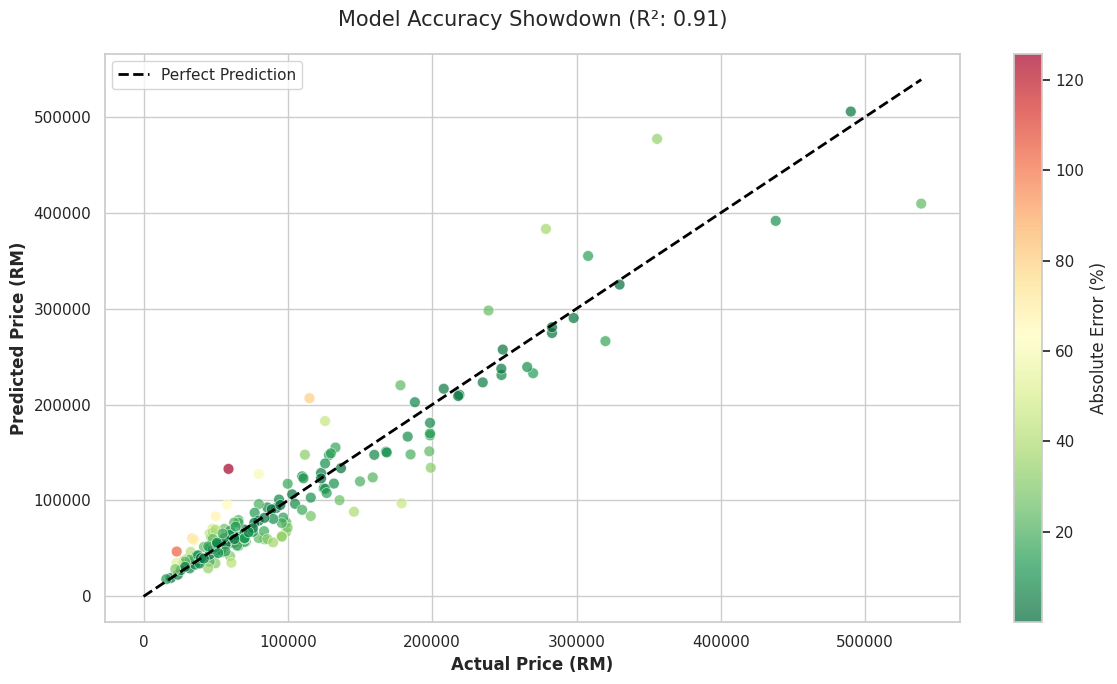

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Calculate the Error for Color Mapping ---
# We calculate the absolute percentage error to see where the model is "off"
error_pct = np.abs((y_true - y_pred) / y_true) * 100

# --- 2. Create the Enhanced Plot ---
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# We use 'hue' to color the dots by their error percentage
# 'coolwarm' or 'RdYlGn_r' (Red-Yellow-Green) makes errors pop
scatter = plt.scatter(x=y_true, y=y_pred,
                      c=error_pct, cmap='RdYlGn_r',
                      alpha=0.7, edgecolors='w', linewidth=0.5, s=60)

# Add the "Perfect Prediction" line
max_val = max(y_true.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', lw=2, label='Perfect Prediction')

# Add a Color Bar to explain the colors
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error (%)', fontsize=12)

# --- 3. Labels and Formatting ---
plt.xlabel('Actual Price (RM)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Price (RM)', fontsize=12, fontweight='bold')
plt.title(f'Model Accuracy Showdown (R²: {r2:.2f})', fontsize=15, pad=20)
plt.legend(loc='upper left')

# Adjust scale if you have outliers (optional: use log scale for luxury cars)
# plt.xscale('log')
# plt.yscale('log')

plt.tight_layout()
plt.show()



**VISUALIZING FEATURE IMPORTANCE**



--- Generating Feature Importance Plot ---


/tmp/ipython-input-1094341543.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')


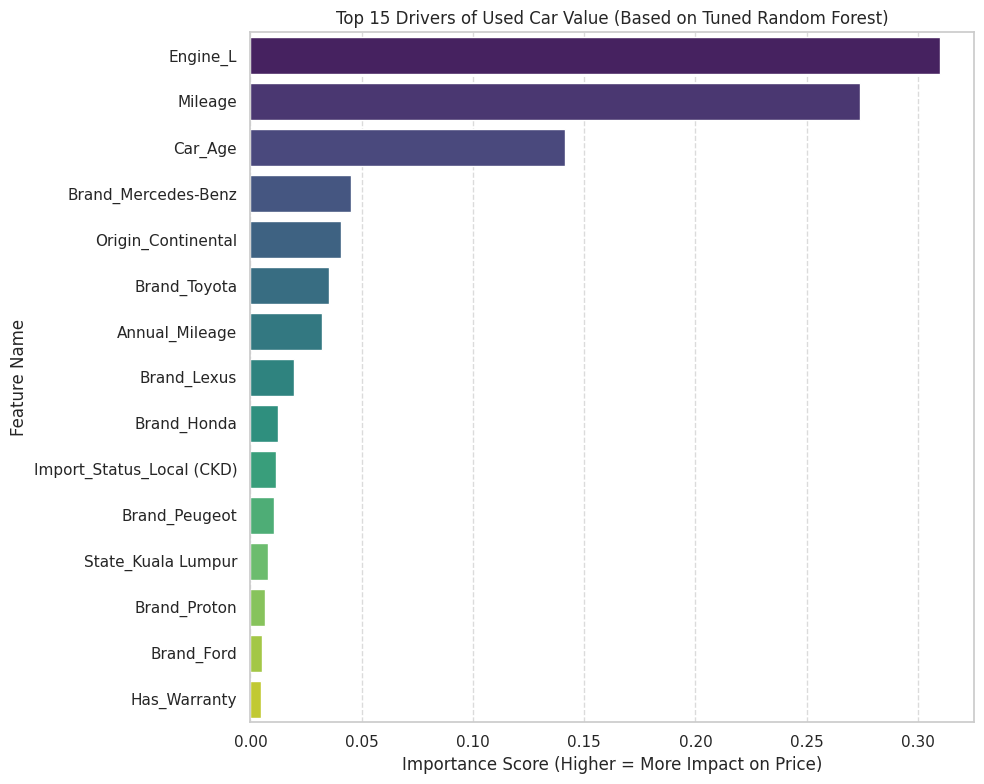


--- Top 5 Most Influential Features ---
            Feature  Importance
           Engine_L    0.309708
            Mileage    0.274117
            Car_Age    0.141183
Brand_Mercedes-Benz    0.045437
 Origin_Continental    0.040817


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- VISUALIZING FEATURE IMPORTANCE ---
print("--- Generating Feature Importance Plot ---")

# 1. Extract Importance Scores from the BEST model (Tuned)
importances = best_rf.feature_importances_
feature_names = X_train.columns

# 2. Create a DataFrame to organize the data
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by Importance (Highest on top) and pick Top 15
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

# 4. Create the Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')

# 5. Add Labels and Titles
plt.title("Top 15 Drivers of Used Car Value (Based on Tuned Random Forest)")
plt.xlabel("Importance Score (Higher = More Impact on Price)")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 6. Show the plot
plt.tight_layout()
plt.show()

# 7. Print the exact numbers for your report
print("\n--- Top 5 Most Influential Features ---")
print(feature_df.head(5)[['Feature', 'Importance']].to_string(index=False))

Test Run

In [48]:
import joblib
import pandas as pd
import numpy as np

# --- 1. SETUP THE PATH ---
# This points to the folder where we just saved your model
model_path = '/content/drive/My Drive/WIA1007/'

def predict_car_price(year, mileage, engine_l, brand, origin, state, import_status, is_warranty):
    # 2. Load the "Brain" and "Map" from Google Drive
    try:
        loaded_model = joblib.load(model_path + 'my_car_price_model.pkl')
        loaded_columns = joblib.load(model_path + 'model_columns.pkl')
    except FileNotFoundError:
        print(f"Error: Could not find files in {model_path}. Did you run the 'Save' code block?")
        return 0

    # 3. Process User Input (Calculations)
    current_year = 2022 # Reference year
    car_age = current_year - year
    # Prevent division by zero
    annual_mileage = mileage / (car_age if car_age > 0 else 1)
    has_warranty = 1 if is_warranty else 0

    # 4. Create a blank table with the exact columns the model expects
    input_data = pd.DataFrame(0, index=[0], columns=loaded_columns)

    # 5. Fill in the Numerical Values
    input_data['Car_Age'] = car_age
    input_data['Mileage'] = mileage
    input_data['Annual_Mileage'] = annual_mileage
    input_data['Engine_L'] = engine_l
    input_data['Has_Warranty'] = has_warranty

    # 6. Fill in the Categorical Values (One-Hot Encoding)
    # The logic: If "Brand_Honda" exists in the trained columns, set it to 1.
    if f"Brand_{brand}" in loaded_columns:
        input_data[f"Brand_{brand}"] = 1

    if f"Origin_{origin}" in loaded_columns:
        input_data[f"Origin_{origin}"] = 1

    if f"State_{state}" in loaded_columns:
        input_data[f"State_{state}"] = 1

    if f"Import_Status_{import_status}" in loaded_columns:
        input_data[f"Import_Status_{import_status}"] = 1

    # 7. Predict!
    log_price_prediction = loaded_model.predict(input_data)[0]
    final_price = np.expm1(log_price_prediction) # Convert Log -> Real Money

    return final_price

# --- TEST YOUR MODEL HERE ---
# Example: 4-Year-Old Honda Civic
print("Testing prediction for a 2018 Honda Civic...")
my_prediction = predict_car_price(
    year=2018,
    mileage=60000,
    engine_l=1.8,
    brand='Honda',
    origin='Asian',
    state='Selangor',
    import_status='Local (CKD)',
    is_warranty=False
)

print(f"💰 Estimated Price: RM {my_prediction:,.2f}")

Testing prediction for a 2018 Honda Civic...
💰 Estimated Price: RM 60,492.42
